In [36]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [37]:
Q_EC_76As=0.9233 #in MeV
Z_76As=33
log_ft_76As=5.0

Q_EC_37Ar=0.81387 #in MeV
Z_37Ar=18
log_ft_37Ar=5.1

g_a_g_v=1.297 #ratio of vector and axial coupling constants

In [38]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [39]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [40]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

Ферми функция по Бакалу: $F(Z, {\epsilon}_e)= \frac{y}{1-e^{-y}}$, где $ {y} = \frac{2{\pi}Z\alpha \epsilon_e}{\pi_e} $

In [41]:
def Columb_func_Bahcall(Pi_e, Z, e_e):
    #ферми функция по Бакалу
    if Pi_e>0:
        y_k=(2*math.pi*Z*e_e)/(Pi_e*137)
        return y_k/(1-math.exp(-y_k))
    else: return 0

### Suslov

In [42]:
Fermi_Sus = pd.read_excel('../../fermi_func_tables/Z=32+1.xlsx')
Fermi_Sus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
E_kev    101 non-null int64
Z=32     101 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


In [43]:
Fermi_Sus['E_meV'] = Fermi_Sus['E_kev']/1000
Fermi_Sus.head()

,E_kev,Z=32,E_meV
0,0,0.000,0.000
1,5,1.567,0.005
2,6,1.432,0.006
3,7,1.327,0.007
4,8,1.243,0.008


In [44]:
def Fermi_Sus_func(e_e):
    #input привиденная энергия электрона
    return np.interp(x = e_e*0.511, xp = Fermi_Sus['E_meV'], 
                     fp = Fermi_Sus['Z=32'])

In [45]:
e_e = np.linspace(0,10,100, endpoint=False)
Suslov = Fermi_Sus_func(e_e-1) #-1 т.к. на вход идет кин. энергия

### Bahcall

In [46]:
pi_e = [Pi_e_func(elem) for elem in e_e]

Bahcall = [Columb_func_Bahcall(pi_value, Z_76As, e_value) for (pi_value, e_value) in 
          zip(pi_e, e_e)]

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

In [47]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/13.xlsx')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 14 columns):
P              49 non-null float64
F0L0           49 non-null float64
L0             48 non-null object
1z             48 non-null float64
13             48 non-null float64
ELECTRON
14    48 non-null float64
Z= 33
Izt      48 non-null float64
A= 77          48 non-null float64
A,             48 non-null float64
A2             48 non-null float64
VI2            48 non-null float64
912            48 non-null float64
12             48 non-null float64
Unnamed: 13    48 non-null float64
dtypes: float64(13), object(1)
memory usage: 5.4+ KB


In [48]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['P'].values ) + 1 )
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

Num_tab =  num_tables_func( e_e )

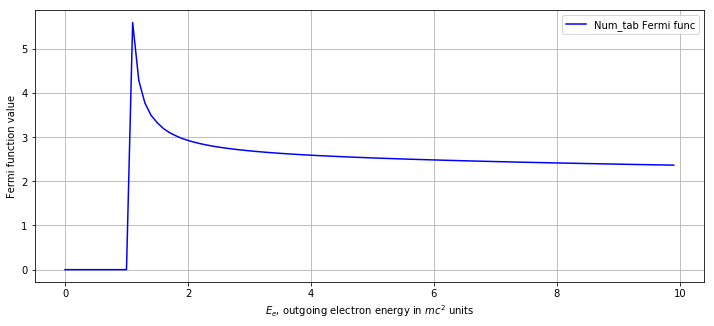

In [71]:
plt.figure(figsize=(12,5))
#plt.plot(e_e, Suslov, c='red', ls=':', label='Suslov Fermi func')
plt.plot(e_e, Num_tab, c='blue', ls='-', label='Num_tab Fermi func')
#plt.plot(e_e, Bahcall, c='green', ls='-.', label='Bahcall Fermi func')
plt.xlabel('$E_e$, outgoing electron energy in $mc^2$ units')
plt.ylabel('Fermi function value')
plt.legend()
plt.grid()
plt.show()

### Cross-section and total rate

Сечение по Иджири $\sigma_k={(1.597\times10^{-44}\ cm^2)}\epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [50]:
def sigma_k_Ejiri_num_tab(E_nu, E_k, BGT_k, Z, Q_EC):
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC)
    Pi_e=Pi_e_func(e_e)
    F_col=num_tables_func(e_e)#ферми функция
    #F_col=Columb_func_Bahcall(Pi_e, Z, e_e)
    return e_e*Pi_e*F_col*math.pow(0.511,2)*math.pow(g_a_g_v,2)*BGT_k*1.597*math.pow(10,-44)

In [51]:
BGT=pd.read_csv('../B(GT) peaks processing/clear_B(GT).csv') #таблица со значениями B(GT)
BGT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
Unnamed: 0        73 non-null int64
Ex                73 non-null float64
Jpi               73 non-null object
diff cross-sec    73 non-null float64
B(GT)             73 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


In [52]:
BGT['B(GT)'] = BGT['B(GT)']/10

In [53]:
fluxes=pd.read_csv('../Vyborov_results/Fluxes/SumFluxes.csv', sep=';')
fluxes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
energy          2000 non-null float64
sum_spectrum    2000 non-null float64
dtypes: float64(2)
memory usage: 31.3 KB


In [54]:
BS05_OP=pd.read_csv('../Vyborov_results/Fluxes/AllFluxes_BS05(OP).csv', sep=';')
BS05_OP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
energy    2000 non-null float64
pp        2000 non-null float64
hep       2000 non-null float64
N         2000 non-null float64
F         2000 non-null float64
O         2000 non-null float64
B         2000 non-null float64
dtypes: float64(7)
memory usage: 109.5 KB


In [55]:
Energy_all_fluxes = np.arange(0,20,0.01)

#метод Иджири, Ферми функция немцев, все возб. состояния
Ej_76As_num_tab_all_fluxes=[sum([sigma_k_Ejiri_num_tab(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                            for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)])
                 for E_nu in Energy_all_fluxes]

all_fluxes_step = 0.01

([<matplotlib.axis.XTick at 0x7f7df1b1b8d0>,
 <a list of 13 Text xticklabel objects>)

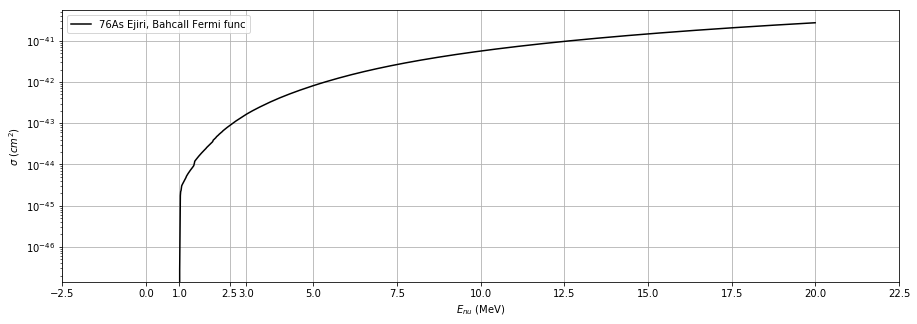

In [56]:
plt.figure(figsize=(15,5))
plt.plot(Energy_all_fluxes, Ej_76As_num_tab_all_fluxes, c='black', markevery=40, label='76As Ejiri, Bahcall Fermi func')
plt.grid()
plt.legend()
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
plt.xticks(list(plt.xticks()[0]) + [1,3])

In [57]:
BS05_OP_dict = {}
for elem in list(BS05_OP.columns)[1:]:
    BS05_OP_dict.update({ elem : 
                        np.interp(x=Energy_all_fluxes, xp=BS05_OP['energy'], 
                                  fp=BS05_OP[elem] ) })

In [58]:
sum_fluxes_no_pep = 0
for elem in list(BS05_OP_dict.keys()):
    flux = sum(BS05_OP_dict[elem]*Ej_76As_num_tab_all_fluxes*all_fluxes_step) * math.pow(10,36)
    print(elem, ' ', flux)
    sum_fluxes_no_pep += flux
print('Total flux no pep', sum_fluxes_no_pep)

N   0.101981181764
F   0.0219055356605
pp   0.0
O   0.860093202034
B   14.9325450351
hep   0.0494961877882
Total flux no pep 15.9660211423


In [59]:
BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

BS05_OP_pep=(BS05_OP_pep_ampl*math.pow(10,36))*sum([
    sigma_k_Ejiri_num_tab(pep_en, E_k, BGT_k, Z_76As, Q_EC_76As) for (BGT_k, E_k) 
    in zip(BGT['B(GT)'].values, BGT['Ex'].values)])

print('pep flux', BS05_OP_pep)
print('Total flux', sum_fluxes_no_pep + BS05_OP_pep)

pep flux 1.43946621379
Total flux 17.4054873561


### BS05_AGS_OP

In [60]:
BS05_AGS_OP=pd.read_csv('../Vyborov_results/Fluxes/AllFluxes.csv', sep=';')
BS05_AGS_OP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
energy    2000 non-null float64
B         2000 non-null float64
F         2000 non-null float64
hep       2000 non-null float64
N         2000 non-null float64
O         2000 non-null float64
pp        2000 non-null float64
dtypes: float64(7)
memory usage: 109.5 KB


In [61]:
BS05_AGS_OP.head()

,energy,B,F,hep,N,O,pp
0,0.00,0.0000,0.000000,0.000000,0.0,0.000000,0.000000e+00
1,0.01,19.3844,1105.149209,0.000000,192872.7,49105.430836,8.260997e+08
2,0.02,38.7688,4317.593143,0.014539,720513.0,193547.428571,3.214779e+09
3,0.03,96.0204,9635.558857,0.033901,1573488.0,430651.285714,7.041704e+09
4,0.04,153.2720,16895.697714,0.056319,2769660.0,757634.142857,1.217081e+10


In [62]:
BS05_AGS_OP_dict = {}
for elem in list(BS05_AGS_OP.columns)[1:]:
    BS05_AGS_OP_dict.update({ elem : 
                        np.interp(x=Energy_all_fluxes, xp=BS05_AGS_OP['energy'], 
                                  fp=BS05_AGS_OP[elem] ) })

In [63]:
sum_fluxes_no_pep_AGS_OP = 0
for elem in list(BS05_AGS_OP_dict.keys()):
    flux = sum(BS05_AGS_OP_dict[elem]*Ej_76As_num_tab_all_fluxes*all_fluxes_step) * math.pow(10,36)
    print(elem, ' ', flux)
    sum_fluxes_no_pep_AGS_OP += flux
print('Total flux no pep', sum_fluxes_no_pep_AGS_OP)

N   0.0666697823455
F   0.0122055844246
pp   0.0
O   0.533405440746
B   11.830564678
hep   0.0515184784368
Total flux no pep 12.494363964


In [64]:
BS05_AGS_OP_pep_ampl=1.45e8
pep_en=1.442 #MeV

BS05_AGS_OP_pep=(BS05_AGS_OP_pep_ampl*math.pow(10,36))*sum([
    sigma_k_Ejiri_num_tab(pep_en, E_k, BGT_k, Z_76As, Q_EC_76As) for (BGT_k, E_k) 
    in zip(BGT['B(GT)'].values, BGT['Ex'].values)])

print('pep flux', BS05_AGS_OP_pep)

pep flux 1.46987747183


In [65]:
BS05_OP_convolution = {'B':14.9325450351,
                       'pp':0.0,
                       'O':0.860093202034,
                       'F':0.0219055356605,
                       'N':0.101981181764,
                       'hep':0.0494961877882,
                       'pep':1.43946621379
                      }

In [66]:
BS05_AGS_OP_convolution = {'N':0.0666697823455,
                           'O':0.533405440746,
                           'F':0.0122055844246,
                           'pp':0.0,
                           'B':11.830564678,
                           'hep':0.0515184784368,
                           'pep':1.46987747183}

In [67]:
Norms = {'BS05_AGS_OP': {'pp': 6.058e10, 'pep': 1.453e8, 'hep': 8.254e3,
'Be1': 4.338e9, 'Be2': 4.338e9, 'B': 4.508e6, 'N': 2.007e8, 'O':1.445e8,
'F': 3.254e6},

'B16_AGSS09': {'pp': 6.03e10, 'pep': 1.46e8, 'hep': 8.25e3,
'Be1': 4.50e9, 'Be2': 4.50e9, 'B': 4.50e6, 'N': 2.04e8, 'O':1.44e8,
'F': 3.26e6}}

In [68]:
B16_AGSS09_convolution = {}
for key in list(BS05_AGS_OP_convolution.keys()):
    conv = BS05_AGS_OP_convolution[key] / Norms['BS05_AGS_OP'][key] * Norms['B16_AGSS09'][key]
    B16_AGSS09_convolution.update({key:conv})

for elem in B16_AGSS09_convolution: print(elem, B16_AGSS09_convolution[elem])

pp 0.0
N 0.06776599700289986
F 0.012228090111922555
pep 1.4769587810542328
O 0.5315597471794049
B 11.80956988708962
hep 0.051493511885582745


In [69]:
sum( list( B16_AGSS09_convolution.values() ) )

13.949576014323663

In [70]:
sum( list( BS05_AGS_OP_convolution.values() ) )

13.964241435782899